Creating your own pix2pix dataset
=================================



## Installation requirements

In [ ]:
import os
import glob
import random
from tqdm import tqdm

import sys

import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage import io
from skimage import filters
from skimage import feature
from tensorflow.keras.preprocessing import image

from IPython.display import clear_output

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/dmlap-final') # change to your favourite dir

Mounted at /content/drive/


## Setting up
Set your directories and the dataset specifics

-   `TARGET_DIR` defines where your **target** images are located.
-   `SOURCE_DIR` defines where your **source** images are located, if you already have these. Otherwise, set this to an empty string `''`.
-   `DATASET_DIR` defines where your pix2pix dataset will be saved.
-   `IS_INPUT_PIX_TO_PIX` set this to `True` if the input dataset already consists of an source and target pairs. This will be the case if you want to modify an existing pix2pix dataset. In this case we need to extract only the target.
-   `INPUT_OUTPUT_TARGET_INDEX` if we are manipulating a dataset that is already a pix2pix dataset, this defines whether the target image is to the left (`0`) or to the right (`1`).

In [ ]:
TARGET_DIR = '/content/drive/MyDrive/dmlap-final/stylegan/stylegan3/out'
SOURCE_DIR = None  # Only used if we already have source image examples

DATASET_DIR = '/content/drive/MyDrive/dmlap-final/dataset-pix2pix/gan_face'
os.makedirs(DATASET_DIR, exist_ok=True)

IS_INPUT_PIX_TO_PIX = False
INPUT_OUTPUT_TARGET_INDEX = 1 # 0: [target, source], 1: [source, target]

## Load the images to process

load  target images, and optionally our source images if we have set the `SOURCE_DIR` directory.

In [ ]:
def load_image(path):
    size = (256, 256)
    if IS_INPUT_PIX_TO_PIX: # In case we are already loading a pix2pix image
        size = (256, 512)
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    # If we are loading a pix2pix dataset just extract the target
    if IS_INPUT_PIX_TO_PIX:
        if INPUT_OUTPUT_TARGET_INDEX == 0:
            img = img[:,:size[0],:]
        else:
            img = img[:,size[0]:,:]
    return img.astype(np.uint8)

def load_images_in_path(path, shuffle=False, limit=0):
    fnames = glob.glob(os.path.join(path, "*"))
    print(f"Found {len(fnames)} files in '{path}'")
    if limit > 0:
        fnames = fnames[:limit]
        print(f"Limiting number of files to {limit}")
    for f in fnames:
        yield load_image(f) # See this: https://realpython.com/introduction-to-python-generators/

Found 767 files in '/content/drive/MyDrive/dmlap-final/stylegan/stylegan3/out'


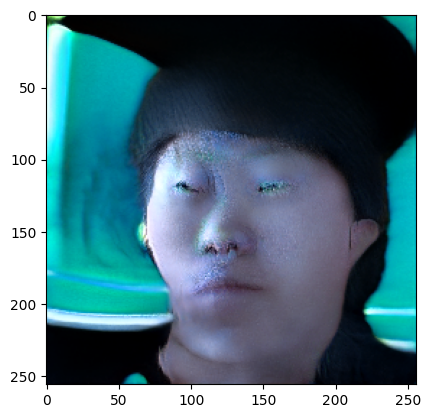

In [ ]:
if SOURCE_DIR:
    source_loader = iter(load_images_in_path(SOURCE_DIR))
    plt.imshow(next(source_loader))
    plt.show()

target_loader = iter(load_images_in_path(TARGET_DIR)) # create an iterator
plt.imshow(next(target_loader))
plt.show()

## Define our transformation



In [ ]:
!pip install mediapipe==0.10.5

The following meidapipe face landmarking code is adapted from:
 https://github.com/googlesamples/mediapipe/blob/main/examples/face_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Face_Landmarker.ipynb


In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmark

In [ ]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

this chunk of code is a test if facelandmarking is working

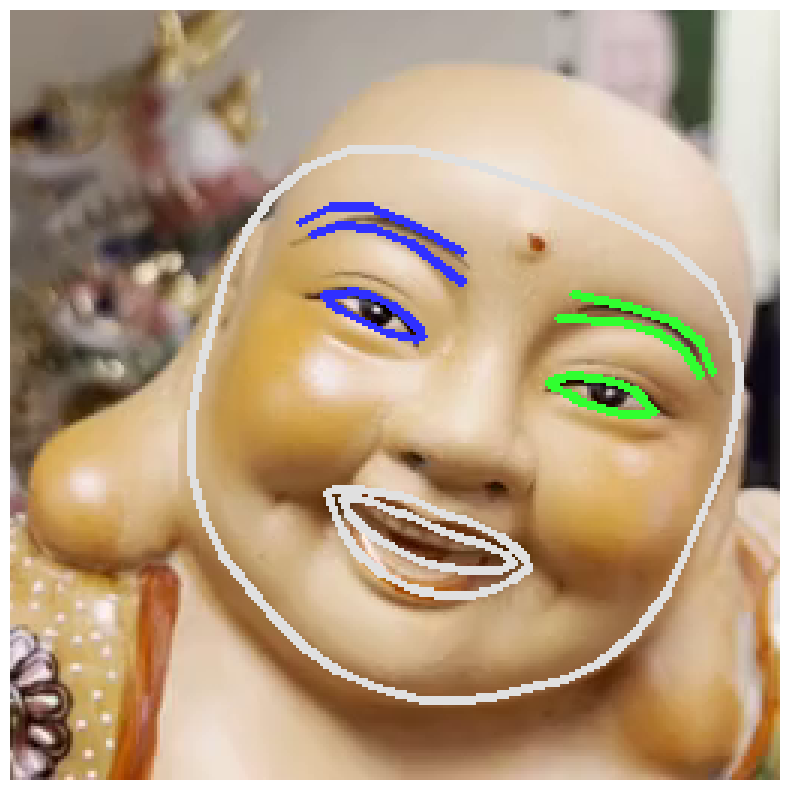

In [ ]:
import mediapipe as mp
image_path = '/content/drive/MyDrive/dmlap-final/Vids/frames/fo/fo1_frame_0001.png'

#load the image
image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# initialize MediaPipe Face Landmarker
mp_face_mesh = solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# process the image and draw landmarks
results = face_mesh.process(rgb_image)
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image=rgb_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles.get_default_face_mesh_contours_style())

# display the annotated image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

see drawing utils configurations here: https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/drawing_utils.py#L32


Found 767 files in '/content/drive/MyDrive/dmlap-final/stylegan/stylegan3/out'


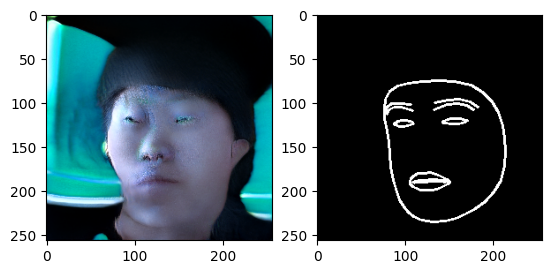

In [ ]:
# thanks chatGPT....
# fucntion that return face image with face landmrk image
import mediapipe as mp
from mediapipe import solutions
def apply_face_landmarks(img, stroke_weight=2):
    # convert the image to RGB
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # initialize MediaPipe Face Landmarker
    mp_face_mesh = solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

    # process the image and draw landmarks
    results = face_mesh.process(rgb_image)

    # create a black image of the same size
    black_image = np.zeros_like(rgb_image)

    # define white color for landmarks
    white_color = (255, 255, 255)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image=black_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=solutions.drawing_utils.DrawingSpec(color=(255, 255, 255)))

    return cv2.cvtColor(black_image, cv2.COLOR_RGB2BGR)

# As it is, this version loads an image from the source_image directory and applies the face landmarks detection
# algorithm to it. Set transform=None if you just want to load that image without processing
def load_source(img, img_source_iterator):
    return next(img_source_iterator)

image_transformation = apply_face_landmarks

img = next(load_images_in_path(TARGET_DIR))
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(image_transformation(img))
plt.show()

## Create the dataset!

Here we loop through all the target images, generate the source image and stitch these together into a single image. The input image directory might contain more than the desired number of images. If we want to process a lower number, set the `num_images` variable to a non-zero value.

In [ ]:
OUTPUT_TARGET_INDEX = 1 # 0: [target, source], 1: [source, target]

NUM_IMAGES = 0 # if you have a lot of images and want to parse only a fraction

img_loader = iter(load_images_in_path(TARGET_DIR, limit=NUM_IMAGES))

def combine_images(source, target):
    if OUTPUT_TARGET_INDEX == 1:
        combined = np.hstack([source, target])
    else:
        combined = np.hstack([target, source])
    return combined

if SOURCE_DIR:
    # CASE 1: we have source images, we want to combine them
    # create a source image iterator
    source_loader = iter(load_images_in_path(SOURCE_DIR, limit=num_images))
    # loop over both source and target and save the combine images
    for i, (source, target) in enumerate(zip(source_loader, img_loader)):
        clear_output(wait=True)
        print(f"Processing image {i}")
        # IDEA: you could also apply additional processing to either your
        # source or target here
        combined = combine_images(source, target)
        io.imsave(os.path.join(DATASET_DIR, f"{i+1}.png"), combined)
else:
    # CASE 2: we only have targets, we create the sources and combine them
    for i, target in enumerate(img_loader):
        clear_output(wait=True)
        print(f"Processing image {i}")

        source = image_transformation(target)
        if source is None:
            print(f"Failed to transform image {i+1}")
            continue

        combined = combine_images(source, target)
        io.imsave(os.path.join(DATASET_DIR, f"{i+1}.png"), combined)